# Assignment 4

## AI usage

## Log

Working on this assignment I am working first on requirements for the Jupyter Notebook and subsequently updating the Streamlit app. 

I really enjoyed working with the same import structure as in Assignment 2, with the Elhub API. However, I realized that the name I chose for the tables (`elhub_api`) in Cassandra and MongoDB weren't descriptive enough, as we now are using two tables from the same API. I was also unsure of whether the new production data from 2022-2024 should be strictly appended to the old tables or if I could remake the tables with data 2021-2024. Manipulating data with Spark and inserting into Cassandra and MongoDB was otherwise fine, mostly following the same structure from Assignment 2.

Updates for the Streamlit app have felt difficult as I haven't caught up with the progress in the lectures. 

## Links 

- Github: https://github.com/Satheris/IND320_SMAA
- Streamlit app: https://ind320smaa-2eg32uba6uhmrknkwtxzar.streamlit.app/

## Coding 

### Imports and system variables

In [40]:
import numpy as np
import pandas as pd 
import streamlit as st
import pymongo
from cassandra.cluster import Cluster
from pyspark.sql import SparkSession
from pyjstat import pyjstat
import requests
import json
import plotly.express as px
from pyspark import SparkConf, SparkContext

import plotly.io as pio
pio.renderers.default = "notebook+pdf+plotly_mimetype"

%matplotlib inline

In [2]:
# Set environment variables for PySpark (system and version dependent!) 
# if not already set persistently (e.g., in .bashrc or .bash_profile or Windows environment variables)
import os
# Set the Java home path to the one you are using ((un)comment and edit as needed):
os.environ["JAVA_HOME"] = r"C:\Program Files\Java\jre1.8.0_471"

# If you are using environments in Python, you can set the environment variables like the alternative below.
# The default Python environment is used if the variables are set to "python" (edit if needed):
os.environ["PYSPARK_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"

# On Windows you need to specify where the Hadoop drivers are located (uncomment and edit if needed):
os.environ["HADOOP_HOME"] = r"C:\Users\saraa\Documents\winutils\hadoop-3.3.1"

# Set the Hadoop version to the one you are using, e.g., none:
os.environ["PYSPARK_HADOOP_VERSION"] = "without"

### Cassandra and Spark

In [3]:
# Connecting to Cassandra
# Run local Docker container first
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

WARNING	cassandra.cluster:cluster.py:__init__()- Cluster.__init__ called with contact_points specified, but no load_balancing_policy. In the next major version, this will raise an error; please specify a load-balancing policy. (contact_points = ['localhost'], lbp = None)
WARNING	cassandra.cluster:cluster.py:protocol_downgrade()- Downgrading core protocol version from 66 to 65 for ::1:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster.Cluster.protocol_version
WARNING	cassandra.cluster:cluster.py:protocol_downgrade()- Downgrading core protocol version from 65 to 5 for ::1:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster.Cluster.protocol_version


In [4]:
# Set up new keyspace
#                                              name of keyspace                        replication strategy           replication factor
session.execute("CREATE KEYSPACE IF NOT EXISTS ind320_keyspace WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : 1 };")

# assign keyspace
session.set_keyspace('ind320_keyspace')

# drop tables to start from scratch every time 
# session.execute("DROP TABLE IF EXISTS ind320_keyspace.elhub_api;")    # table used in Assignment 2
session.execute("DROP TABLE IF EXISTS ind320_keyspace.elhub_production;")
session.execute("DROP TABLE IF EXISTS ind320_keyspace.elhub_consumption;")

# Create new tables 
session.execute("CREATE TABLE IF NOT EXISTS elhub_production \
                (ind int PRIMARY KEY, startTime text, endTime text, lastUpdatedTime text, \
                productionGroup text, quantityKwh float, \
                priceArea text);")
session.execute("CREATE TABLE IF NOT EXISTS elhub_consumption \
                (ind int PRIMARY KEY, startTime text, endTime text, lastUpdatedTime text, \
                consumptionGroup text, quantityKwh float, \
                priceArea text, meteringPointCount int)")

In [5]:
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.5.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').\
    config('spark.driver.host', 'localhost').\
    config('spark.driver.bindAddress', '127.0.0.1').\
    config('spark.sql.adaptive.enabled', 'true').\
        getOrCreate()

#### Testing that the connection works

In [6]:
# .load() is used to load data from Cassandra table as a Spark DataFrame
spark.read.format("org.apache.spark.sql.cassandra").options(table="my_first_table", keyspace="my_first_keyspace").load().show()

+---+--------+-------+
|ind| company|  model|
+---+--------+-------+
|  2|   Tesla|Model 3|
|  3|Polestar|      3|
|460|    Ford|Transit|
|459|    Ford| Escort|
|  1|   Tesla|Model S|
+---+--------+-------+



### MongoDB

In [7]:
def init_connection():
    return pymongo.MongoClient(st.secrets["mongo"]["uri"])

client = init_connection()

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


### Elhub API

#### Production data

In [8]:
# initating lists for traversing the URL
years = [2021, 2022, 2023, 2024, 2025]
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


all_records = []

for i, year in enumerate(years[:-1]):
    for j, month in enumerate(months):

        # catching last month with adapted URL for end time
        if month == months[-1]:
            URL = 'https://api.elhub.no/energy-data/v0/price-areas?dataset=PRODUCTION_PER_GROUP_MBA_HOUR&'\
                f'startDate={year}-{month}-01T00:00:00%2B02:00&endDate={years[i+1]}-{months[0]}-01T00:00:00%2B02:00'
            
        # all other months follow the same structure
        else: 
            URL = 'https://api.elhub.no/energy-data/v0/price-areas?dataset=PRODUCTION_PER_GROUP_MBA_HOUR&'\
                f'startDate={year}-{month}-01T00:00:00%2B02:00&endDate={year}-{months[j+1]}-01T00:00:00%2B02:00'

        payload = { 
            "query": [], 
            "response": { "format": "json-stat2" } }

        response = requests.get(URL, json=payload)
        
        # print(f"Y:{year}, m:{month}, Status Code: {response.status_code}")

        data = response.json()

        for area in data['data']:
            records = area['attributes']['productionPerGroupMbaHour']
            for record in records:
                record['priceArea'] = area['attributes']['name']
                all_records.append(record)

elhub_production = pd.DataFrame(all_records)
elhub_production.index.name = 'ind'
elhub_production = elhub_production.reset_index()

print(f"\nCreated DataFrame with {len(elhub_production)} rows")
elhub_production.head()


Created DataFrame with 872953 rows


,ind,endTime,lastUpdatedTime,priceArea,productionGroup,quantityKwh,startTime
0,0,2021-01-01T01:00:00+01:00,2024-12-20T10:35:40+01:00,NO1,hydro,2507716.8,2021-01-01T00:00:00+01:00
1,1,2021-01-01T02:00:00+01:00,2024-12-20T10:35:40+01:00,NO1,hydro,2494728.0,2021-01-01T01:00:00+01:00
2,2,2021-01-01T03:00:00+01:00,2024-12-20T10:35:40+01:00,NO1,hydro,2486777.5,2021-01-01T02:00:00+01:00
3,3,2021-01-01T04:00:00+01:00,2024-12-20T10:35:40+01:00,NO1,hydro,2461176.0,2021-01-01T03:00:00+01:00
4,4,2021-01-01T05:00:00+01:00,2024-12-20T10:35:40+01:00,NO1,hydro,2466969.2,2021-01-01T04:00:00+01:00


#### Consumption data

In [9]:
# initating lists for traversing the URL
years = [2021, 2022, 2023, 2024, 2025]
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


all_records = []

for i, year in enumerate(years[:-1]):
    for j, month in enumerate(months):
        
        # catching last month with adapted URL for end time
        if month == months[-1]:
            URL = 'https://api.elhub.no/energy-data/v0/price-areas?dataset=CONSUMPTION_PER_GROUP_MBA_HOUR&'\
                f'startDate={year}-{month}-01T00:00:00%2B02:00&endDate={years[i+1]}-{months[0]}-01T00:00:00%2B02:00'
        
        # all other months follow the same structure
        else: 
            URL = 'https://api.elhub.no/energy-data/v0/price-areas?dataset=CONSUMPTION_PER_GROUP_MBA_HOUR&'\
                f'startDate={year}-{month}-01T00:00:00%2B02:00&endDate={year}-{months[j+1]}-01T00:00:00%2B02:00'

        payload = { 
            "query": [], 
            "response": { "format": "json-stat2" } }

        response = requests.get(URL, json=payload)
        
        # print(f"Y:{year}, m:{month}, Status Code: {response.status_code}")

        data = response.json()

        for area in data['data']:
            records = area['attributes']['consumptionPerGroupMbaHour']
            for record in records:
                record['priceArea'] = area['attributes']['name']
                all_records.append(record)

elhub_consumption = pd.DataFrame(all_records)
elhub_consumption.index.name = 'ind'
elhub_consumption = elhub_consumption.reset_index()

print(f"\nCreated DataFrame with {len(elhub_consumption)} rows")
elhub_consumption.head()


Created DataFrame with 876600 rows


,ind,consumptionGroup,endTime,lastUpdatedTime,meteringPointCount,priceArea,quantityKwh,startTime
0,0,cabin,2021-01-01T01:00:00+01:00,2024-12-20T10:35:40+01:00,100607,NO1,177071.56,2021-01-01T00:00:00+01:00
1,1,cabin,2021-01-01T02:00:00+01:00,2024-12-20T10:35:40+01:00,100607,NO1,171335.12,2021-01-01T01:00:00+01:00
2,2,cabin,2021-01-01T03:00:00+01:00,2024-12-20T10:35:40+01:00,100607,NO1,164912.02,2021-01-01T02:00:00+01:00
3,3,cabin,2021-01-01T04:00:00+01:00,2024-12-20T10:35:40+01:00,100607,NO1,160265.77,2021-01-01T03:00:00+01:00
4,4,cabin,2021-01-01T05:00:00+01:00,2024-12-20T10:35:40+01:00,100607,NO1,159828.69,2021-01-01T04:00:00+01:00


In [10]:
# I found that the columns in the Cassandra table was constructed with lowercase letters.
# Therefore, I need to convert the column names to lowercase before writing to Cassandra

str_list = ['elhub_production', 'elhub_consumption']

for i, table in enumerate([elhub_production, elhub_consumption]):
    name_dict = {}
    for capitalname in (table.columns):
        name_dict[capitalname] = capitalname.lower()
    
    table = table.rename(columns=name_dict)

    # Convert the Pandas DataFrame to Spark DataFrame and save it to Cassandra (append mode)
    spark.createDataFrame(table).write.format('org.apache.spark.sql.cassandra')\
    .options(table=str_list[i], keyspace='ind320_keyspace').mode('append').save()

    print(f'Saved {str_list[i]} to Cassandra')

Saved elhub_production to Cassandra
Saved elhub_consumption to Cassandra


### Saving dfs to MongoDB

In [11]:
# Selecting a database and a collection
database = client['project']

for table in str_list:
    collection = database[table]
    collection.delete_many({}) # starting fresh

    spark.read.format("org.apache.spark.sql.cassandra")\
    .options(table=table, keyspace="ind320_keyspace").load()\
    .createOrReplaceTempView(f"{table}_view")

    df_spark = spark.sql(f"SELECT priceArea, {table.split('_')[1]}Group, startTime, quantityKwh FROM {table}_view")

    # Convert DataFrame to JSON and dumping to MongoDB
    df_pd = df_spark.toPandas()
    json_data = df_pd.to_json(orient='records')

    documents = json.loads(json_data)
    try: 
        collection.insert_many(documents)
        print(f'Successfully inserted {table} to MongoDB')
    except Exception as e:
        print(e)

Successfully inserted elhub_production to MongoDB
Successfully inserted elhub_consumption to MongoDB


### Stopping Spark session

In [12]:
# Stop Spark session
try:
    spark.stop()
    print('Spark session terminated successfully')
except ConnectionRefusedError:
    print("Spark session already stopped.")
except NameError:
    print('Spark session is not defined')

Spark session terminated successfully


### Testing for Streamlit app

#### Plotly map

In [17]:
# import plotly.graph_objects as go

# with open(r'C:\Users\saraa\Documents\IND320_SMAA\project\data\file.geojson') as file: 
#     priceAreas = json.load(file)

# fig = px.choropleth(geojson=priceAreas,
#                     locations='fips',
#                     featureidkey='properties.id',
#                     )

# fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
# fig.update_geos(fitbounds="locations", visible=True)


# # # Create figure
# # fig = go.Figure()

# # # Add choropleth mapbox (even without data values, just for outlines)
# # fig.add_trace(go.Choroplethmap(
# #     geojson=priceAreas,
# #     locations=[],  # Empty since we just want outlines
# #     featureidkey="properties.id",  # Adjust based on your GeoJSON structure
# #     z=[],  # Empty data
# #     colorscale="Blues",  # Doesn't matter since no data
# #     showscale=False,  # Hide color scale
# #     marker_line_width=2,  # Outline width
# #     marker_opacity=0,  # Transparent fill
# #     marker_line_color="black"  # Outline color
# # ))

# # # Update layout with mapbox style
# # fig.update_layout(
# #     mapbox_style="open-street-map",
# #     mapbox_zoom=10,
# #     mapbox_center={"lat": 40.7, "lat": -73.9},  # Adjust to your area
# #     margin={"r":0,"t":0,"l":0,"b":0}
# # )

#### Snow drift 


Yearly average snow drift (Qt) per season:
Overall average Qt over all seasons: 14.5 tonnes/m

Yearly average snow drift (Qt) per season (in tonnes/m) and control type:
   season Qt (tonnes/m)         Control
2021-2022          14.1 Wind controlled
2022-2023          13.4 Wind controlled
2023-2024          16.1 Wind controlled

Overall average Qt over all seasons: 14.5 tonnes/m


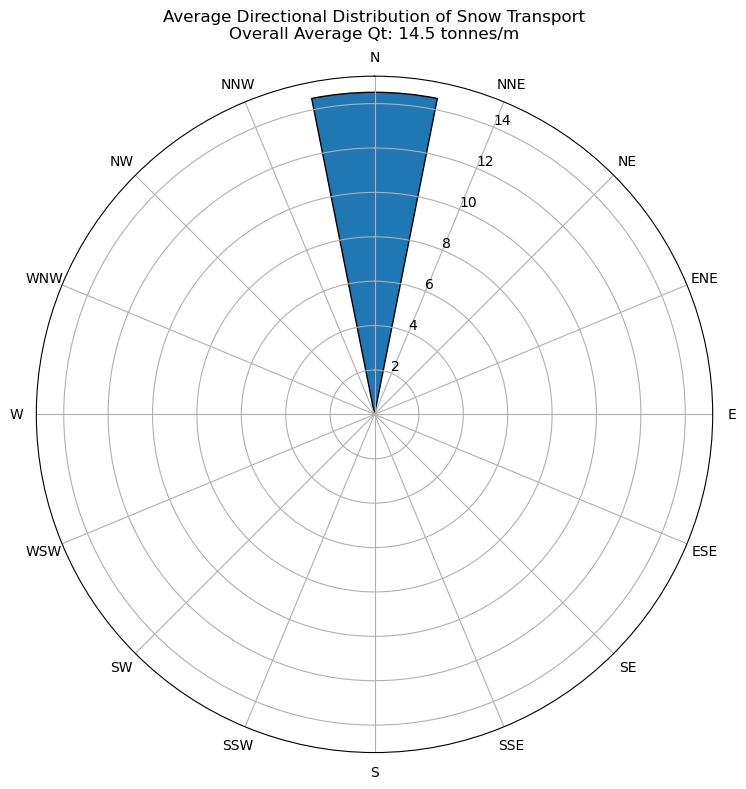


Necessary fence heights per season (in meters):
   season Wyoming (m) Slat-and-wire (m) Solid (m)
2021-2022         1.3               1.3       2.1
2022-2023         1.2               1.3       2.0
2023-2024         1.3               1.4       2.2


In [49]:
from utils.snowdrift import snowdrift_plot
from utils.common import area_to_geoplacement
import openmeteo_requests
import requests_cache
from retry_requests import retry

# from utils/common.py
# modified to download July-June time period
def openmeteo_download_snowdrift(area, startYear=2021, endYear=2022) -> pd.DataFrame:
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    longitude, latitude = area_to_geoplacement(area)

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": f"{startYear}-07-01",
        "end_date": f"{endYear}-06-30",
        "hourly": ["temperature_2m", "precipitation", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"],
        "models": "era5",
        "timezone": "Europe/Berlin",
        "wind_speed_unit": "ms"}
    
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]    

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_wind_direction_10m = hourly.Variables(1).ValuesAsNumpy()
    hourly_wind_speed_10m = hourly.Variables(2).ValuesAsNumpy()
    hourly_wind_gusts_10m = hourly.Variables(3).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()

    hourly_data = {"time": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True), # .tz_convert('Europe/Oslo'),
        end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True), # .tz_convert('Europe/Oslo'),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left")}
    
    hourly_data['time'] = pd.to_datetime(hourly_data['time']).tz_localize(None) + pd.Timedelta(hours=1)

    hourly_data["temperature_2m (°C)"] = hourly_temperature_2m
    hourly_data["wind_direction_10m (°)"] = hourly_wind_direction_10m
    hourly_data["wind_speed_10m (m/s)"] = hourly_wind_speed_10m
    hourly_data["wind_gusts_10m (m/s)"] = hourly_wind_gusts_10m
    hourly_data["precipitation (mm)"] = hourly_precipitation

    df = pd.DataFrame(data = hourly_data)

    return df

# openmeteo_download_snowdrift('NO1')

snowdrift_plot(openmeteo_download_snowdrift('NO1', endYear=2024))

#### Meteorology

#### Forecasting energy data 